In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

/home/barbara/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Animals names dataset

# with open('animals_names.txt', 'r') as file:
#     data = file.read()

# # Split the data into a list of names
# words = [name.lower() for name in data.split(',')]

# # Print the list to verify
# print(words[:10])

# for w in words:
#     if "'" in w or "-" in w or "(" in w or ")" in w:
#         words.remove(w)

In [3]:
# all_names_string = ''.join(words)

# # Create a set of unique characters
# unique_characters = set(all_names_string)

# # Print the unique characters
# print(unique_characters)

In [4]:
# People names dataset
words = open("names.txt", 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
# Vocabulary
chars = [c for c in '.abcdefghijklmnopqrstuvwxyz']

# Convertion between characters and integers
itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

In [6]:
block_size = 3
def build_dataset(names):
    X, Y = [], []

    for name in names:
        c1 = [0] * block_size
        for ch in name + '.':
            X.append(c1)
            Y.append(stoi[ch])
            c1 = c1[1:] + [stoi[ch]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

In [7]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
n_emb = 10 # dimension of embeddings
n_hidden = 200 # number of neurons on the hidden layer
vocab_size = len(chars) # size of the vocabulary

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),           generator=g)
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn((n_hidden),                   generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),       generator=g) * 0.1
b2 = torch.randn((vocab_size),                 generator=g) * 0
parameters = [C, W1, b1, W2, b2]

W2 and b2 should be lower values so that the initial probabilities of each character in the vocab is equal, resulting in a lower initial loss

W1 and b1 shoudl be lower so we dont get dead neurons due to tanh

In [9]:
# Number of parameters
print(sum(p.numel() for p in parameters), "parameters")
for p in parameters:
    p.requires_grad = True

11897 parameters


In [16]:
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):    
    
    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    #Forward pass
    emb = C[Xb]
    hidden_state = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = hidden_state @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr

    losses.append(loss.log10().item())


### Analyzing activations

(array([  9.,  13.,  35.,  42.,  46.,  60.,  73., 101., 102., 108., 122.,
        145., 150., 146., 160., 157., 187., 151., 157., 176., 162., 197.,
        205., 175., 203., 180., 187., 182., 208., 181., 199., 170., 179.,
        176., 142., 194., 179., 159., 131., 133., 122., 122., 123.,  78.,
         99.,  61.,  45.,  37.,  23.,   8.]),
 array([-0.96745062, -0.9285777 , -0.88970478, -0.85083186, -0.81195894,
        -0.77308602, -0.7342131 , -0.69534019, -0.65646727, -0.61759435,
        -0.57872143, -0.53984851, -0.50097559, -0.46210267, -0.42322975,
        -0.38435683, -0.34548391, -0.30661099, -0.26773808, -0.22886516,
        -0.18999224, -0.15111932, -0.1122464 , -0.07337348, -0.03450056,
         0.00437236,  0.04324528,  0.0821182 ,  0.12099112,  0.15986403,
         0.19873695,  0.23760987,  0.27648279,  0.31535571,  0.35422863,
         0.39310155,  0.43197447,  0.47084739,  0.50972031,  0.54859323,
         0.58746614,  0.62633906,  0.66521198,  0.7040849 ,  0.74295782,
 

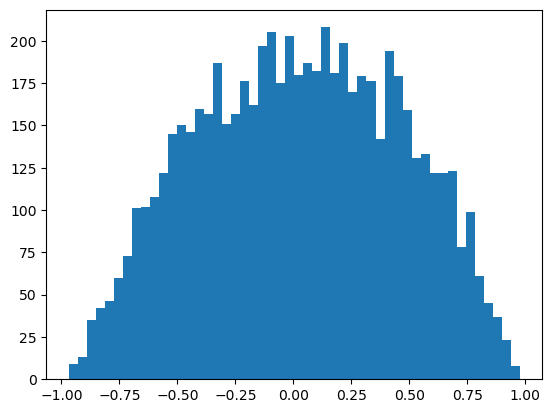

In [11]:
plt.hist(hidden_state.view(-1).tolist(), 50)

if the neurons have activations of -1 and 1 they will hardly have their gradients updated, because of the way backpropgation is calculated in tanh

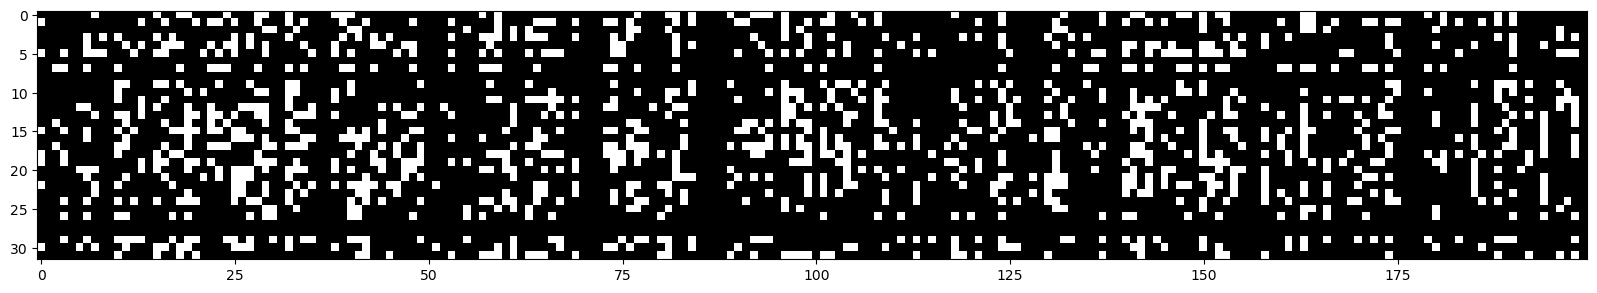

In [17]:
# If a column is all white it means a dead neuron
plt.figure(figsize=(20, 5))
plt.imshow(hidden_state.abs() > 0.99, cmap='gray', interpolation='nearest')

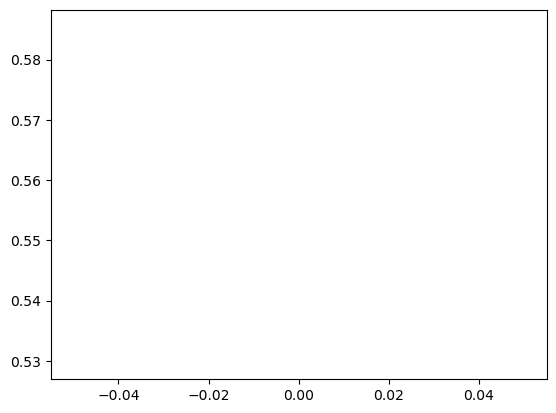

In [13]:
plt.plot(losses)

In [18]:
# Calculate loss on validation set
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    hidden_state = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = hidden_state @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('dev')

train loss: 2.0550243854522705
dev loss: 2.1140296459198


In [21]:
g = torch.Generator().manual_seed(42)

for _ in range(15):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join([itos[i] for i in out[:-1]]))

anueden
tia
marian
dan
shan
silayley
kemarco
man
epsachaden
dazi
kendrif
berlei
lor
marinyn
becvesia
